## PyTorch/XLA ResNet18/CIFAR10 (GPU or TPU)

### [RUNME] Install Colab compatible PyTorch/XLA wheels and dependencies



In [ ]:
# !pip install cloud-tpu-client==0.10 torch==1.12.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.12-cp37-cp37m-linux_x86_64.whl

### If you're using GPU with this colab notebook, run the below commented code to install GPU compatible PyTorch wheel and dependencies

In [ ]:
#!pip install cloud-tpu-client==0.10 torch==1.12.0 https://storage.googleapis.com/tpu-pytorch/wheels/cuda/112/torch_xla-1.12-cp37-cp37m-linux_x86_64.whl --force-reinstall 

### Only run the below commented cell if you would like a nightly release

In [ ]:
# VERSION = "1.12"  #@param ["1.12", "nightly", "20220315"]  # or YYYYMMDD format
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version $VERSION
# import os 
# os.environ['LD_LIBRARY_PATH']='/usr/local/lib'
# !echo $LD_LIBRARY_PATH

# !sudo ln -s /usr/local/lib/libmkl_intel_lp64.so /usr/local/lib/libmkl_intel_lp64.so.1
# !sudo ln -s /usr/local/lib/libmkl_intel_thread.so /usr/local/lib/libmkl_intel_thread.so.1
# !sudo ln -s /usr/local/lib/libmkl_core.so /usr/local/lib/libmkl_core.so.1

# !ldconfig
# !ldd /usr/local/lib/python3.7/dist-packages/torch/lib/libtorch.so

In [1]:
# PyTorch/XLA GPU Setup (only if GPU runtime)
import os
if os.environ.get('COLAB_GPU', '0') == '1':
  os.environ['GPU_NUM_DEVICES'] = '1'
  os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda/'

In [1]:
import os 

data_dir = "~/Documents/Research/robust_likelihood/ood_classifier_data/"

ood_labels = ['normal', 'ood']
splits = ['train', 'test']
ood_types = ["overlay", "splice", "shuffle", "noise", "add_noise", "mask_splice", "svhn"]
ind_classes = ['airplane',  'automobile',  'bird',  'cat',  'deer',  'dog',  'frog',  'horse',  'ship',  'truck']

ind_source = "~/Documents/Research/Datasets/CIFAR-10-images/"
ood_source = "~/Documents/Research/robust_likelihood/ood_data/"

ood_train = ["overlay", "splice", "shuffle", "noise", "add_noise", "mask_splice"]
ood_test = ["svhn"]
# ood_test_source = "~/Documents/Research/robust_likelihood/ood_data/test/splice/"

# ind_train_dst = train_dir + ind_train_source[ind_train_source[:-1].rfind("/")+1:-1]
# ind_test_dst = test_dir + ind_test_source[ind_test_source[:-1].rfind("/")+1:-1]

# ood_train_dst = train_dir + ood_train_source[ood_train_source[:-1].rfind("/")+1:-1]
# ood_test_dst = test_dir + ood_test_source[ood_test_source[:-1].rfind("/")+1:-1]

os.system("rm -rf ~/Documents/Research/robust_likelihood/ood_classifier_data/*")

for split in splits:
    for label in ood_labels:
        os.makedirs(f"{data_dir}{split}/{label}/", exist_ok=True)

# os.makedirs("/home/mrlennon/Documents/Research/robust_likelihood/ood_classifier_data/train")
# os.makedirs("/home/mrlennon/Documents/Research/robust_likelihood/ood_classifier_data/test")
# os.system(f"ln -s {ind_train_source} {train_dir}; mv {ind_train_dst} {train_dir+ind_label_rename}")
# os.system(f"ln -s {ood_train_source} {train_dir}; mv {ood_train_dst} {train_dir+ood_label_rename}")
# os.system(f"ln -s {ind_test_source} {test_dir}; mv {ind_test_dst} {test_dir+ind_label_rename}")
# os.system(f"ln -s {ood_test_source} {test_dir}; mv {ood_test_dst} {test_dir+ood_label_rename}")

0

### Define Parameters



In [5]:
# Result Visualization Helper
from matplotlib import pyplot as plt

M, N = 4, 6
RESULT_IMG_PATH = './test_result.jpg'
CIFAR10_LABELS = ['normal', 'spliced']

def plot_results(images, labels, preds):
  images, labels, preds = images[:M*N], labels[:M*N], preds[:M*N]
  inv_norm = transforms.Normalize(
      mean=(-0.4914/0.2023, -0.4822/0.1994, -0.4465/0.2010),
      std=(1/0.2023, 1/0.1994, 1/0.2010))

  num_images = images.shape[0]
  fig, axes = plt.subplots(M, N, figsize=(16, 9))
  fig.suptitle('Correct / Predicted Labels (Red text for incorrect ones)')

  for i, ax in enumerate(fig.axes):
    ax.axis('off')
    if i >= num_images:
      continue
    img, label, prediction = images[i], labels[i], preds[i]
    img = inv_norm(img)
    img = img.permute(1, 2, 0) # (C, M, N) -> (M, N, C)
    label, prediction = label.item(), prediction.item()
    if label == prediction:
      ax.set_title(u'\u2713', color='blue', fontsize=22)
    else:
      ax.set_title(
          'X {}/{}'.format(CIFAR10_LABELS[label],
                          CIFAR10_LABELS[prediction]), color='red')
    ax.imshow(img)
  plt.savefig(RESULT_IMG_PATH, transparent=True)

In [6]:
# Define Parameters
FLAGS = {}
FLAGS['data_dir'] = "~/Documents/Research/robust_likelihood/ood_classifier_data/"
FLAGS['batch_size'] = 128
FLAGS['num_workers'] = 4
FLAGS['learning_rate'] = 0.0005
FLAGS['momentum'] = 0.9
FLAGS['num_epochs'] = 10
FLAGS['num_cores'] = 8 if os.environ.get('TPU_NAME', None) else 1
FLAGS['log_steps'] = 20
FLAGS['metrics_debug'] = False

In [9]:
import torchvision
from torchvision import datasets, transforms

debug_train_dset = torchvision.datasets.ImageFolder(FLAGS['data_dir']+"train/")
cifar_classes = debug_train_dset.find_classes(debug_train_dset.root)

In [58]:
len(cifar_classes[0])

2

In [10]:
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# import torch_xla
# import torch_xla.core.xla_model as xm
# import torch_xla.debug.metrics as met
# import torch_xla.distributed.parallel_loader as pl
# import torch_xla.distributed.xla_multiprocessing as xmp
# import torch_xla.utils.utils as xu

activation = F.relu

class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, in_planes, planes, stride=1):

    super(BasicBlock, self).__init__()

    self.activation = activation

    self.conv1 = nn.Conv2d(
        in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(
        planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion * planes:
      self.shortcut = nn.Sequential(
          nn.Conv2d(
              in_planes,
              self.expansion * planes,
              kernel_size=1,
              stride=stride,
              bias=False), nn.BatchNorm2d(self.expansion * planes))

  def forward(self, x):
    out = self.activation(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = self.activation(out)
    return out


class ResNet(nn.Module):

  def __init__(self, block, num_blocks, num_classes=10):
    super(ResNet, self).__init__()
    self.in_planes = 64

    self.conv1 = nn.Conv2d(
        3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
    self.linear = nn.Linear(512 * block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks - 1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    out = activation(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = torch.flatten(out, 1)
    out = self.linear(out)
    return F.log_softmax(out, dim=1)


def ResNet18():
  return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=len(cifar_classes[0]))

In [ ]:
WRAPPED_MODEL = ResNet18()

In [11]:
# SERIAL_EXEC = xmp.MpSerialExecutor()
# Only instantiate model weights once in memory.

def train_resnet18():
  torch.manual_seed(1)

  def get_dataset():
    norm = transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
    transform_train = transforms.Compose([
        transforms.RandomResizedCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        norm,
    ])
    transform_test = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        norm,
    ])
    train_dataset = datasets.ImageFolder(
        root=FLAGS['data_dir']+"train/",
        transform=transform_train)
    test_dataset = datasets.ImageFolder(
        root=FLAGS['data_dir']+"test/",
        transform=transform_test)
    
    return train_dataset, test_dataset
  
  # Using the serial executor avoids multiple processes
  # to download the same data.
  train_dataset, test_dataset = get_dataset()

  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=FLAGS['batch_size'],
      drop_last=True,
      shuffle=True)
  test_loader = torch.utils.data.DataLoader(
      test_dataset,
      batch_size=FLAGS['batch_size'],
      shuffle=True,
      drop_last=True)

  # Scale learning rate to num cores
  learning_rate = FLAGS['learning_rate']

  # Get loss function, optimizer, and model
  device = "cuda:0"
  model = WRAPPED_MODEL.to(device)
  optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                        momentum=FLAGS['momentum'], weight_decay=5e-4)
  loss_fn = nn.NLLLoss()

  def train_loop_fn(loader):
    model.train()
    for x, (data, target) in enumerate(loader):
      optimizer.zero_grad()
      output = model(data.to(device))
      loss = loss_fn(output, target.long().to(device))
      loss.backward()
      optimizer.step()

  def test_loop_fn(loader):
    total_samples = 0
    correct = 0
    model.eval()
    data, pred, target = None, None, None
    for data, target in loader:
      output = model(data.to(device))
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(target.view_as(pred).to(device)).sum().item()
      total_samples += data.size()[0]

    accuracy = 100.0 * correct / total_samples
    print('Accuracy={:.2f}%'.format(
        accuracy), flush=True)
    return accuracy, data, pred, target

  # Train and eval loops
  accuracy = 0.0
  data, pred, target = None, None, None
  for epoch in range(1, FLAGS['num_epochs'] + 1):
    train_loop_fn(train_loader)
    print("Finished training epoch {}".format(epoch))

    accuracy, data, pred, target  = test_loop_fn(test_loader)

  return accuracy, data, pred, target
  

Finished training epoch 1
Accuracy=59.49%
Finished training epoch 2
Accuracy=62.76%
Finished training epoch 3
Accuracy=81.29%
Finished training epoch 4
Accuracy=84.24%
Finished training epoch 5
Accuracy=87.47%
Finished training epoch 6
Accuracy=94.11%
Finished training epoch 7
Accuracy=91.94%
Finished training epoch 8
Accuracy=92.01%
Finished training epoch 9
Accuracy=97.41%
Finished training epoch 10
Accuracy=97.16%


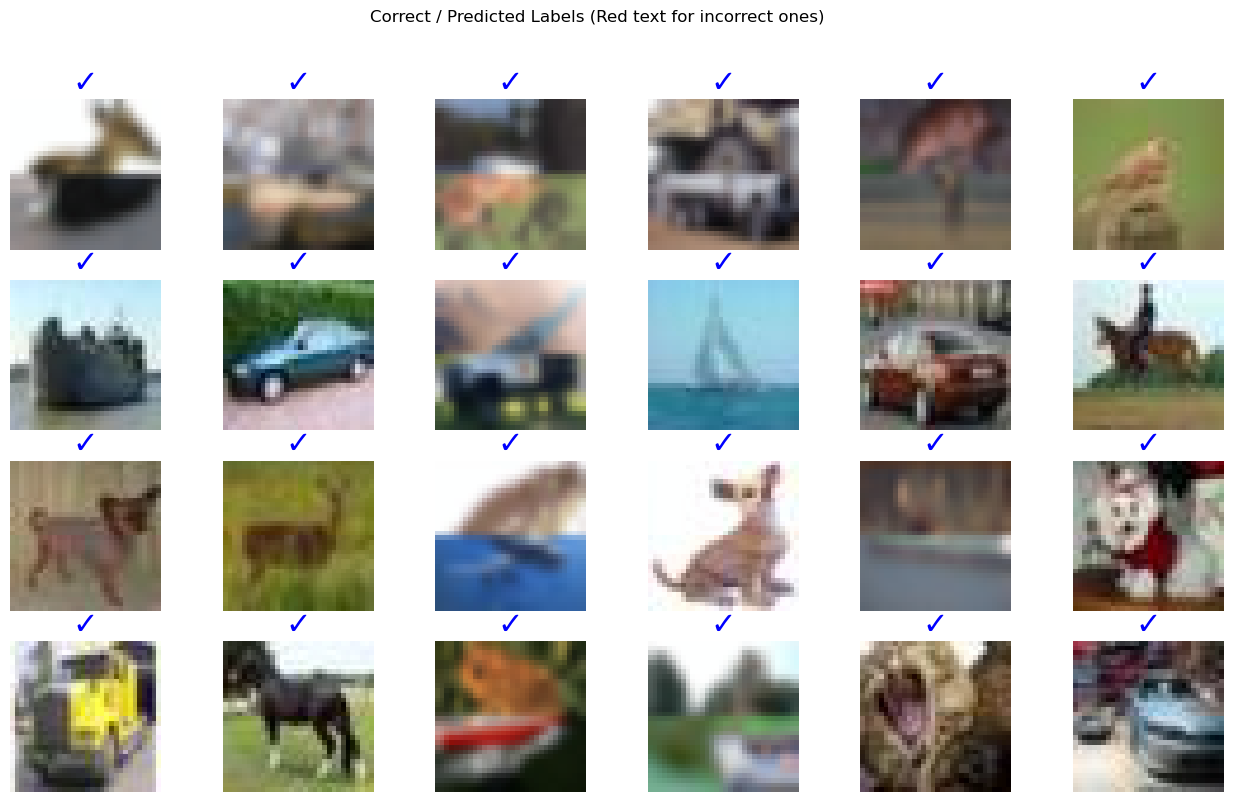

In [12]:
# Start training processes
# def _mp_fn(rank, flags):
# global FLAGS
# FLAGS = flags
torch.set_default_tensor_type('torch.FloatTensor')
accuracy, data, pred, target = train_resnet18()
plot_results(data.cpu(), pred.cpu(), target.cpu())

# xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=FLAGS['num_cores'],
#           start_method='fork')

## Visualize Predictions

In [23]:
# from google.colab.patches import cv2_imshow
import cv2
img = cv2.imread(RESULT_IMG_PATH, cv2.IMREAD_UNCHANGED)
cv2.imshow("image",img)

: 

: 

In [32]:
import glob
from PIL import Image

for filename in glob.iglob("/home/mrlennon/Documents/Research/Datasets/CIFAR-10-images/test/*/*.*"):
    img = Image.open(filename)
    assert img.height == 32